In [1]:
import numpy as np
import online_utils as utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import optimize, stats
from matplotlib.colors import Normalize

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Experimental setting

In [2]:
n = 10000
p_r = np.linspace(n/100, n, 200).astype(int) # range for values of p
L_r = np.linspace(1, 0.2*n, 200).astype(int) # range for values of L

c_r = p_r/n
eps_r = (2*L_r-1)/n

# Initialisation

In [3]:
pht_batch = np.sqrt(np.divide(*np.meshgrid(p_r, L_r))).T  # phase transition of batch learning: sqrt(p/L)
pht_batch_equiv = np.sqrt(2/(np.sqrt(1+4*np.divide(*np.meshgrid(L_r, p_r))*(1+n/p_r[:, None]))-1)) # batch with L' s.t. Lp + Ln = L'p + L'^2
pht_punct = np.zeros((p_r.size, L_r.size))
pht_online = np.zeros((p_r.size, L_r.size))

mu2_r = np.linspace(1/200, 1, 200) # range for values of ||mu||^2
error_rate = lambda zeta: stats.norm.sf(np.sqrt(zeta/(1-zeta))) # asymptotic online clustering error
zeta_c = np.zeros((p_r.size, L_r.size, mu2_r.size))

k_nu = 2*np.pi*np.arange(n)/n

# Computations

Phase transitions

In [4]:
a, b = 1e-5, 50 # interval for root search
for i, (L, eps) in enumerate(zip(L_r.astype(float), tqdm(eps_r))):
    psi = utils.nu(L, k_nu)
    for j, (c, p) in enumerate(zip(c_r, p_r)):
        func_punct = lambda t: t**4+2*t**3+(1-c/eps)*t**2-2*c*t-c
        func_online = lambda t: p*np.mean((psi/((t+1)*psi[0]-psi))**2)-1
        # Puncturing
        if func_punct(a)*func_punct(b) < 0:
            res_punct = optimize.root_scalar(func_punct, method='brentq', bracket=[a, b])
            pht_punct[j, i] = res_punct.root if res_punct.converged else np.nan
        else:
            pht_punct[j, i] = np.nan
        # Online
        if func_online(a)*func_online(b) < 0:
            res_online = optimize.root_scalar(func_online, method='brentq', bracket=[a, b])
            pht_online[j, i] = res_online.root if res_online.converged else np.nan
        else:
            pht_online[j, i] = np.nan
        for k, mu2 in enumerate(mu2_r): # also compute the theoretical alignment of the dominant eigenvector
            zeta_c[j, i, k] = mu2*(1-c*np.sum((psi/((mu2+1)*(2*L-1)-psi))**2))/(mu2+1)

100%|█████████▉| 199/200 [05:50<00:01,  1.76s/it]


Boundary $\varepsilon_\text{b}$

In [5]:
eps_b = np.zeros(c_r.size)

def func_b(eps, c):
    mu2 = np.sqrt(2/(np.sqrt(1+2*eps*(1+1/c)/c)-1))
    return 1-c*(1/(mu2**2)+2*np.sum(((mu2+1)/np.sinc(eps*range_l)-1)**(-2)))

a, b = 1e-3, 0.2
range_l = np.arange(1, n//2)
for j, c in enumerate(tqdm(c_r)):
    if func_b(a, c)*func_b(b, c) < 0:
        res_b = optimize.root_scalar(lambda t: func_b(t, c), method='brentq', bracket=[a, b])
        eps_b[j] = res_b.root if res_b.converged else np.nan
    else:
        eps_b[j] = np.nan

100%|██████████| 200/200 [00:00<00:00, 258.78it/s]


# Plots

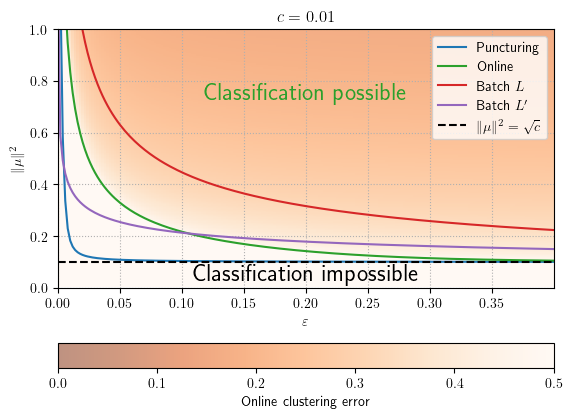

In [6]:
i = 0
right = eps_r[-1]
top = mu2_r[-1]
mesh = plt.pcolormesh(eps_r, mu2_r, error_rate(np.maximum(zeta_c[i], 0)).T, norm=Normalize(0, 0.5), cmap='Oranges_r', alpha=0.5)
cbar = plt.colorbar(mesh, orientation='horizontal')
cbar.set_label("Online clustering error")
plt.plot(eps_r, pht_punct[i], color='C0', label="Puncturing")
plt.plot(eps_r, pht_online[i], color='C2', label="Online")
plt.plot(eps_r, pht_batch[i], color='C3', label="Batch $L$")
plt.plot(eps_r, pht_batch_equiv[i], color='C4', label="Batch $L'$")
plt.axhline(y=np.sqrt(c_r[i]), ls='--', color='black', label="$\\| \\mu \\|^2 = \\sqrt{c}$")
plt.grid(ls=':')
plt.xlim(0, right)
plt.ylim(0, top)
plt.text(right/2, 3*top/4, "Classification possible", color='C2', fontsize='xx-large', fontweight='bold', ha='center', va='center')
plt.text(right/2, np.sqrt(c_r[i])/2, "Classification impossible", color='black', fontsize='xx-large', fontweight='bold', ha='center', va='center')
plt.xlabel("$\\varepsilon$")
plt.ylabel("$\\| \\mu \\|^2$")
plt.legend()
plt.title("$c = {}$".format(c_r[i]));

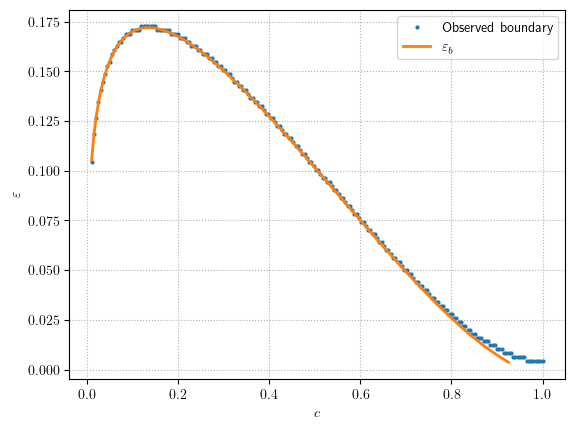

In [7]:
idx_b = np.nanargmin(np.abs(pht_online-pht_batch_equiv), axis=1)

plt.plot(c_r, eps_r[idx_b], ls='', marker='.', markersize=4, label="Observed boundary")
plt.plot(c_r, eps_b, linewidth=2, label="$\\varepsilon_b$")
plt.grid(ls=':')
plt.xlabel("$c$")
plt.ylabel("$\\varepsilon$")
plt.legend();